Forecasting of hourly taxi rides in ten clusters is performed using both Random Forest and LSTM models. Random Forest handles structured features well, while LSTM captures temporal dependencies in the time series. Using both approaches allows comparison of their predictive strengths.

# Imports

In [100]:
import os
import pandas as pd
import re
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import joblib
from datetime import timedelta
from sklearn.model_selection import BaseCrossValidator

# Loading the data

In [75]:
# Loading the preprocessed dataframes of the 10 clusters
input_dir = "../data/processed"

def extract_cluster_num(filename):
    match = re.search(r"forecast_cluster_(\d+)\.csv", filename)
    return int(match.group(1)) if match else -1

files = [f for f in os.listdir(input_dir) if f.startswith("forecast_cluster_") and f.endswith(".csv")]
files.sort(key=extract_cluster_num)

for filename in files:
    cluster_id = extract_cluster_num(filename)
    file_path = os.path.join(input_dir, filename)
    df = pd.read_csv(file_path, parse_dates=['messagetimestamp'])
    globals()[f"cluster_{cluster_id}"] = df  
    print(f"Loaded cluster {cluster_id} into variable cluster_{cluster_id}")

Loaded cluster 0 into variable cluster_0
Loaded cluster 1 into variable cluster_1
Loaded cluster 2 into variable cluster_2
Loaded cluster 3 into variable cluster_3
Loaded cluster 4 into variable cluster_4
Loaded cluster 5 into variable cluster_5
Loaded cluster 6 into variable cluster_6
Loaded cluster 7 into variable cluster_7
Loaded cluster 8 into variable cluster_8
Loaded cluster 9 into variable cluster_9


In [76]:
cluster_0.head(3)

,messagetimestamp,geo_cluster,temperature_c,precipitation_mm
0,2014-04-01 00:01:00,0,11.7,0.0
1,2014-04-01 00:06:00,0,11.7,0.0
2,2014-04-01 00:07:00,0,11.7,0.0


# Preparing the data

In [77]:
# Prepare each cluster for forecasting by dropping 'geo_cluster',
# converting timestamps, aggregating rides hourly, and filling gaps with zeros.
for i in range(10):
    df = globals()[f"cluster_{i}"]
    
    # Drop 'geo_cluster' column because it is not needed anymore
    df = df.drop(columns=['geo_cluster'])
    
    # Ensure 'messagetimestamp' is datetime type
    df['messagetimestamp'] = pd.to_datetime(df['messagetimestamp'])
    
    # Set datetime as index for resampling
    df.set_index('messagetimestamp', inplace=True)
    
    # Aggregate rides per hour by counting rows
    rides_per_hour = df.resample('h').size()
    
    # Aggregate temperature per hour by mean
    temp_per_hour = df['temperature_c'].resample('h').mean()
    
    # Aggregate precipitation per hour by mean
    prcp_per_hour = df['precipitation_mm'].resample('h').mean()
    
    # Fill missing hours with 0 rides
    rides_per_hour = rides_per_hour.asfreq('h', fill_value=0)
    
    # Keep NaNs in weather data
    temp_per_hour = temp_per_hour.asfreq('h')
    prcp_per_hour = prcp_per_hour.asfreq('h')
    
    # Combine into one DataFrame
    hourly_counts = pd.DataFrame({
        'messagetimestamp': rides_per_hour.index,
        'rides_per_hour': rides_per_hour.values,
        'temperature_c': temp_per_hour.values,
        'precipitation_mm': prcp_per_hour.values
    })
    
    # Add 'hour' and 'dayofweek' columns for model features
    hourly_counts['hour'] = hourly_counts['messagetimestamp'].dt.hour
    hourly_counts['dayofweek'] = hourly_counts['messagetimestamp'].dt.dayofweek
    # Add a monotonically increasing hour index (0, 1, 2, ..., n)
    hourly_counts['hour_index'] = range(len(hourly_counts))
    
    # Save the processed DataFrame back to the global variable
    globals()[f"cluster_{i}"] = hourly_counts

In [79]:
# Taking a look at on of the dataframes to check the previous preparation steps
cluster_0.head(3)

,messagetimestamp,rides_per_hour,temperature_c,precipitation_mm,hour,dayofweek,hour_index
0,2014-04-01 00:00:00,34,11.7,0.0,0,1,0
1,2014-04-01 01:00:00,16,9.4,0.0,1,1,1
2,2014-04-01 02:00:00,12,6.7,0.0,2,1,2


# Forecasting with Random Forest

## 1. Baseline Model Evaluation Using Sliding Window Approach

- Systematic evaluation of short-term demand forecasting using time-series data from ten spatially distinct taxi demand clusters.
- For each cluster, a sliding window approach is applied:
- The model is trained on a fixed-length historical window (4 weeks).
- It predicts taxi ride demand for the following 24 hours.
- The training and testing windows shift forward four weeks, repeating across the dataset to simulate real-time forecasting.
- The baseline model uses only three temporal features — hourofday, dayofweek and hour_index— to capture recurring demand patterns.
- This simple setup allows focused assessment of general forecasting ability without external/contextual factors.
- Results provide insights for further model refinement and feature expansion.

In [80]:
def sliding_window_evaluation(df, window_size_hours=672, forecast_horizon_hours=24, unwanted_features=['messagetimestamp', 'rides_per_hour', 'precipitation_mm','temperature_c'], params = None):
    """
    Sliding window evaluation with Random Forest:
    - window_size_hours: size of the training window in hours (672 = 4 weeks)
    - forecast_horizon_hours: prediction horizon in hours (24 = 1 day)
    """
    rmse_scores = []
    total_hours = len(df)
    feature_cols = [col for col in df.columns if col not in unwanted_features]
    print("The following features are used ", feature_cols)

    start = 0
    while start + window_size_hours + forecast_horizon_hours <= total_hours:
        train = df.iloc[start : start + window_size_hours]
        test = df.iloc[start + window_size_hours : start + window_size_hours + forecast_horizon_hours]
        
        X_train = train[feature_cols]
        y_train = train['rides_per_hour']
        
        X_test = test[feature_cols]
        y_test = test['rides_per_hour']
        if params is None:
            model = RandomForestRegressor(n_estimators=100, random_state=42)
        else:
            model = RandomForestRegressor(**params, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
        
        # Shift by rolling window
        start += window_size_hours
    
    return np.mean(rmse_scores), rmse_scores


In [81]:
# Evaluation parameters
window_size_hours = 4 * 7 * 24  # 4 weeks = 672 hours
forecast_horizon_hours = 24     # 1 day

results_baseline = {}

# Evaluate each cluster with fixed 4-week training window
for i in range(10):
    df = globals()[f"cluster_{i}"]
    
    print(f"\nEvaluating Cluster {i}")
    
    if len(df) < window_size_hours + forecast_horizon_hours:
        print(f"  Cluster {i}: Not enough data for 4-week window, skipping")
        continue

    avg_rmse, all_rmse = sliding_window_evaluation(
        df,
        window_size_hours=window_size_hours,
        forecast_horizon_hours=forecast_horizon_hours
    )

    results_baseline[i] = avg_rmse
    print(f"  4-week Window: Avg. RMSE = {avg_rmse:.2f}")


Evaluating Cluster 0
The following features are used  ['hour', 'dayofweek', 'hour_index']
  4-week Window: Avg. RMSE = 55.55

Evaluating Cluster 1
The following features are used  ['hour', 'dayofweek', 'hour_index']
  4-week Window: Avg. RMSE = 12.88

Evaluating Cluster 2
The following features are used  ['hour', 'dayofweek', 'hour_index']
  4-week Window: Avg. RMSE = 44.59

Evaluating Cluster 3
The following features are used  ['hour', 'dayofweek', 'hour_index']
  4-week Window: Avg. RMSE = 4.53

Evaluating Cluster 4
The following features are used  ['hour', 'dayofweek', 'hour_index']
  4-week Window: Avg. RMSE = 11.10

Evaluating Cluster 5
The following features are used  ['hour', 'dayofweek', 'hour_index']
  4-week Window: Avg. RMSE = 13.65

Evaluating Cluster 6
The following features are used  ['hour', 'dayofweek', 'hour_index']
  4-week Window: Avg. RMSE = 5.43

Evaluating Cluster 7
The following features are used  ['hour', 'dayofweek', 'hour_index']
  4-week Window: Avg. RMSE = 

### Key Findings About the Performance of the Baseline Model: 
#### Best performance (lowest RMSE):
- Cluster 3: RMSE = 4.53
- Cluster 6: RMSE = 5.43
#### Worst performance:
- Cluster 0: RMSE = 55.55
- Cluster 7: RMSE = 103.63
#### Conclusion:
- Prediction quality varies significantly across clusters.
- Most other clusters show moderate performance, with RMSE values around 11–14.
The results suggest that the three temporal features alone are often not sufficient to capture the complexity of demand patterns — they work well in isolated cases (e.g. Cluster 3), but perform poorly in others (e.g. Cluster 7).

## 2. Enriched Feature Model

- Time-based and lag features are added to enrich the dataset and improve forecasting accuracy.
- Features like dayofweek, is_weekend and several lag-features (consecutive weekdays and weeks)
- A sliding window approach with step-length four weeks simulates real-time forecasting using recent history.
- This setup evaluates how enriched features improve demand prediction over time.

In [82]:
def add_time_features(df):
    """
    Adds time-based, holiday (US + NY), and lag-based features to the input DataFrame.
    Assumes a 'messagetimestamp' column (datetime) and 'rides_per_hour' as target.
    """
    df = df.copy()

    # Convert to datetime
    df['messagetimestamp'] = pd.to_datetime(df['messagetimestamp'])

    # Sort for lag correctness
    df = df.sort_values('messagetimestamp')

    # Time-based features
    df['hour'] = df['messagetimestamp'].dt.hour
    df['dayofweek'] = df['messagetimestamp'].dt.dayofweek
    df['month'] = df['messagetimestamp'].dt.month
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

    # US national + NY state holidays
    years = df['messagetimestamp'].dt.year.unique()
    us_ny_holidays = holidays.US(years=years, state='NY')
    df['_is_holiday'] = df['messagetimestamp'].dt.date.isin(us_ny_holidays).astype(int)

    # Lag features
    df['lag_1'] = df['rides_per_hour'].shift(1)
    df['lag_2'] = df['rides_per_hour'].shift(2)
    df['lag_3'] = df['rides_per_hour'].shift(3)
    df['lag_6'] = df['rides_per_hour'].shift(6)
    df['lag_12'] = df['rides_per_hour'].shift(12) # 12 hours
    df['lag_18'] = df['rides_per_hour'].shift(18) 
    df['lag_24'] = df['rides_per_hour'].shift(24) # 1 day
    df['lag_48'] = df['rides_per_hour'].shift(48) # 2 days
    df['lag_72'] = df['rides_per_hour'].shift(72) # 3 days
    df['lag_96'] = df['rides_per_hour'].shift(96) # 4 days
    df['lag_120'] = df['rides_per_hour'].shift(120) # 5 days
    df['lag_144'] = df['rides_per_hour'].shift(144) # 6 days
    df['lag_168'] = df['rides_per_hour'].shift(168) # 1 week
    df['lag_672'] = df['rides_per_hour'].shift(672) # 1 month

    # Remove NaNs from lag
    df = df.dropna()

    return df

# Apply feature engineering to all clusters named cluster_0 to cluster_9
for i in range(10):
    cluster_name = f"cluster_{i}"
    cluster_df = globals()[cluster_name]
    
    # Apply time feature engineering
    cluster_df = add_time_features(cluster_df)
    
    # Overwrite original cluster variable
    globals()[cluster_name] = cluster_df

In [83]:
cluster_0.head(2)

,messagetimestamp,rides_per_hour,temperature_c,precipitation_mm,hour,dayofweek,hour_index,month,is_weekend,_is_holiday,...,lag_12,lag_18,lag_24,lag_48,lag_72,lag_96,lag_120,lag_144,lag_168,lag_672
672,2014-04-29 00:00:00,39,17.8,0.0,0,1,672,4,0,0,...,87.0,149.0,32.0,497.0,372.0,94.0,59.0,39.0,35.0,34.0
673,2014-04-29 01:00:00,29,15.0,0.0,1,1,673,4,0,0,...,129.0,171.0,14.0,304.0,514.0,67.0,46.0,28.0,17.0,16.0


In [84]:
# Evaluation parameters
window_size_hours = 4 * 7 * 24  # 4 weeks = 672 hours
forecast_horizon_hours = 24     # 1 day

results_enriched = {}

# Evaluate each cluster with fixed 4-week training window
for i in range(10):
    df = globals()[f"cluster_{i}"]
    
    print(f"\nEvaluating Cluster {i}")
    
    if len(df) < window_size_hours + forecast_horizon_hours:
        print(f"  Cluster {i}: Not enough data for 4-week window, skipping")
        continue

    avg_rmse, all_rmse = sliding_window_evaluation(df) # using the default values of the function

    results_enriched[i] = avg_rmse
    print(f"  4-week Window: Avg. RMSE = {avg_rmse:.2f}")


Evaluating Cluster 0
The following features are used  ['hour', 'dayofweek', 'hour_index', 'month', 'is_weekend', '_is_holiday', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_18', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_672']
  4-week Window: Avg. RMSE = 37.42

Evaluating Cluster 1
The following features are used  ['hour', 'dayofweek', 'hour_index', 'month', 'is_weekend', '_is_holiday', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_18', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_672']
  4-week Window: Avg. RMSE = 10.41

Evaluating Cluster 2
The following features are used  ['hour', 'dayofweek', 'hour_index', 'month', 'is_weekend', '_is_holiday', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_18', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_672']
  4-week Window: Avg. RMSE = 31.38

Evaluating Cluster 3
The following features are used  ['hour', 'dayofweek', 'hour_index

### Key Findings About the Performance of the Enriched Feature Model: 
- The inclusion of additional temporal, holiday, and lag features significantly improved performance in many clusters (e.g. Cluster 0: RMSE dropped from 55.55 → 37.42).
- However, Cluster 7 remains problematic with a very high RMSE of 83.76, indicating the model may be unable to capture its demand pattern even with enriched features.
Overall, the enriched feature set leads to more stable and lower RMSEs across most clusters.
#### Particularly strong improvements in:
- Cluster 0 (- 32.64 %)
- Cluster 2 (- 29.63 %),
- Cluster 7 (- 19.19 %)
- Cluster 8 (- 28.89%).

## 3. Adding the weather Features 

- In the following step, weather variables such as temperature and precipitation are added to the feature set to assess their contribution to predictive performance.
- The same sliding window approach is applied.
- This evaluation helps determine whether environmental factors enhance the model’s ability to explain and predict variations in ride demand.

In [85]:
# Evaluation parameters
window_size_hours = 4 * 7 * 24  # 4 weeks = 672 hours
forecast_horizon_hours = 24     # 1 day

results_weather_enriched = {}

# Evaluate each cluster with fixed 4-week training window
for i in range(10):
    df = globals()[f"cluster_{i}"]
    
    print(f"\nEvaluating Cluster {i}")
    
    if len(df) < window_size_hours + forecast_horizon_hours:
        print(f"  Cluster {i}: Not enough data for 4-week window, skipping")
        continue

    avg_rmse, all_rmse = sliding_window_evaluation(
        df,
        window_size_hours=window_size_hours,
        forecast_horizon_hours=forecast_horizon_hours, unwanted_features=['messagetimestamp', 'rides_per_hour']
    )

    results_weather_enriched[i] = avg_rmse
    print(f"  4-week Window: Avg. RMSE = {avg_rmse:.2f}")


Evaluating Cluster 0
The following features are used  ['temperature_c', 'precipitation_mm', 'hour', 'dayofweek', 'hour_index', 'month', 'is_weekend', '_is_holiday', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_18', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_672']
  4-week Window: Avg. RMSE = 38.36

Evaluating Cluster 1
The following features are used  ['temperature_c', 'precipitation_mm', 'hour', 'dayofweek', 'hour_index', 'month', 'is_weekend', '_is_holiday', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_18', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_672']
  4-week Window: Avg. RMSE = 10.47

Evaluating Cluster 2
The following features are used  ['temperature_c', 'precipitation_mm', 'hour', 'dayofweek', 'hour_index', 'month', 'is_weekend', '_is_holiday', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_18', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_672']
  4-week Win

### Key Findings About the Performance of the Weather Enriched Model
- RMSEs stayed nearly the same as the enriched model across all clusters.
- Weather features added little benefit, suggesting limited predictive value.
- Cluster 7 remains a clear outlier with high error (83.52).
- Most clusters are well-predicted using just temporal and lag features.

## 4. Comparison of the Baseline Model and the Model with the Enhanced Features and the Weather Enriched Model

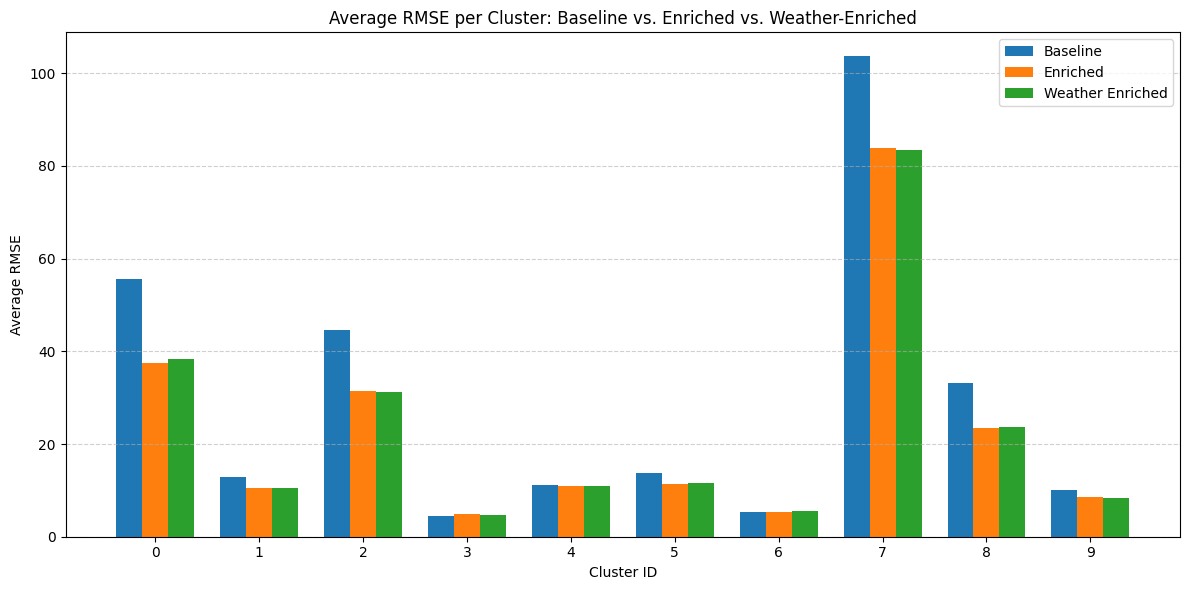

In [88]:
# Prepare lists for plotting
clusters = sorted(results_baseline.keys())
baseline_avgs = []
enriched_avgs = []
weather_enriched_avgs = []

# Compute average RMSEs over all window sizes
for cluster_id in clusters:
    baseline_vals = results_baseline[cluster_id]
    enriched_vals = results_enriched[cluster_id]
    weather_vals = results_weather_enriched[cluster_id]

    baseline_avgs.append(baseline_vals)
    enriched_avgs.append(enriched_vals)
    weather_enriched_avgs.append(weather_vals)

# Plot
x = np.arange(len(clusters))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, baseline_avgs, width, label='Baseline')
plt.bar(x, enriched_avgs, width, label='Enriched')
plt.bar(x + width, weather_enriched_avgs, width, label='Weather Enriched')

plt.xlabel('Cluster ID')
plt.ylabel('Average RMSE')
plt.title('Average RMSE per Cluster: Baseline vs. Enriched vs. Weather-Enriched')
plt.xticks(x, clusters)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [90]:
# Create a DataFrame with all three results
rmse_comparison_df = pd.DataFrame({
    "Cluster": clusters,
    "Baseline_Avg_RMSE": np.round(baseline_avgs, 2),
    "Enriched_Avg_RMSE": np.round(enriched_avgs, 2),
    "Weather_Enriched_Avg_RMSE": np.round(weather_enriched_avgs, 2)
})

# Percentage improvement: Baseline → Enriched
rmse_comparison_df["Improvement_Baseline_to_Enriched_%"] = (
    100 * (rmse_comparison_df["Baseline_Avg_RMSE"] - rmse_comparison_df["Enriched_Avg_RMSE"])
    / rmse_comparison_df["Baseline_Avg_RMSE"]
).round(2)

# Percentage improvement: Enriched → Weather Enriched
rmse_comparison_df["Improvement_Enriched_to_Weather_%"] = (
    100 * (rmse_comparison_df["Enriched_Avg_RMSE"] - rmse_comparison_df["Weather_Enriched_Avg_RMSE"])
    / rmse_comparison_df["Enriched_Avg_RMSE"]
).round(2)

# Display the table
rmse_comparison_df

,Cluster,Baseline_Avg_RMSE,Enriched_Avg_RMSE,Weather_Enriched_Avg_RMSE,Improvement_Baseline_to_Enriched_%,Improvement_Enriched_to_Weather_%
0,0,55.55,37.42,38.36,32.64,-2.51
1,1,12.88,10.41,10.47,19.18,-0.58
2,2,44.59,31.38,31.17,29.63,0.67
3,3,4.53,4.80,4.77,-5.96,0.63
4,4,11.10,11.04,10.97,0.54,0.63
5,5,13.65,11.33,11.51,17.00,-1.59
6,6,5.43,5.39,5.51,0.74,-2.23
7,7,103.63,83.76,83.52,19.17,0.29
8,8,33.06,23.51,23.77,28.89,-1.11
9,9,10.03,8.51,8.42,15.15,1.06


In [63]:
rmse_comparison_df['Improvement_Enriched_to_Weather_%'].mean()

np.float64(-0.47400000000000003)

### Key Findings: Comparison of the Baseline Model, the Enriched Feature Model, and the Weather-Enriched Model
- Enriched features substantially reduce RMSE in most clusters — with improvements up to 32.6% (Cluster 0).
- Largest RMSE reductions occur in Clusters 0, 2, and 8 (≈29–33%), confirming the added value of lag and calendar features.
- Minimal or no improvement is observed in Clusters 3, 4, and 6, likely due to already low baseline RMSE.
#### Adding weather features results in mixed effects:
- Slight improvement in some clusters (e.g. Cluster 2: +0.67%, Cluster 4: +0.63%, Cluster 9: +1.06%),
- Slight deterioration in others (e.g. Cluster 0: –2.5%, Cluster 6: –2.2%).
- Thus, weather data has limited and inconsistent predictive value in this context.
- Overall, enriched features drive most of the performance gain, while weather variables offer only marginal additional benefit.

## 5. Grid Seach to find the best Combination of Hyperparameters for each cluster

- Since some clusters (e.g., Cluster 2 and 7) still show relatively high test RMSE, further fine-tuning is required to improve model accuracy.
- A Random Forest Regressor is used to model hourly ride demand for each cluster.
- An expanded hyperparameter grid is defined to explore a wider range of model configurations.
- TimeSeriesSplit is applied to ensure proper cross-validation for time-dependent data.
- A GridSearchCV is used to identify the best combination of hyperparameters per cluster.
- The tuning is performed separately for each cluster to account for their individual patterns.
- The best model is chosen based on the lowest negative RMSE score from cross-validation.

In [91]:
# Deleting the weather features since they don't improve the model

weather_features = ['temperature_c', 'precipitation_mm']

for i in range(10):
    cluster_df = globals()[f'cluster_{i}']
    cluster_df = cluster_df.drop(columns=weather_features, errors='ignore')
    globals()[f'cluster_{i}'] = cluster_df

In [92]:
class SlidingWindowSplit(BaseCrossValidator):
    """
    Time series cross-validator with a sliding window.

    For each split, trains on a window of size `window_size` and tests on the next `forecast_horizon` steps.
    The window moves forward by `window_size` each time (non-overlapping).
    """

    def __init__(self, window_size, forecast_horizon):
        self.window_size = window_size
        self.forecast_horizon = forecast_horizon

    def get_n_splits(self, X=None, y=None, groups=None):
        if X is None:
            raise ValueError("X must be provided to compute number of splits")
        return (len(X) - self.window_size - self.forecast_horizon) // self.window_size + 1

    def split(self, X, y=None, groups=None):
        total_size = len(X)
        start = 0
        while start + self.window_size + self.forecast_horizon <= total_size:
            train_idx = np.arange(start, start + self.window_size)
            test_idx = np.arange(start + self.window_size, start + self.window_size + self.forecast_horizon)
            yield train_idx, test_idx
            start += self.window_size

In [93]:
# List with the 10 cluster DataFrames
clusters = [cluster_0, cluster_1, cluster_2, cluster_3, cluster_4, 
            cluster_5, cluster_6, cluster_7, cluster_8, cluster_9]

# Dictionary to store best models and best params
best_model_dict = {}
best_params_dict = {}

# Parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# TimeSeriesSplit for CV
tscv = SlidingWindowSplit(window_size=672, forecast_horizon=24)

for i, df in enumerate(clusters):
    print(f"\nProcessing Cluster {i}")
    
    unwanted_features = ['messagetimestamp', 'rides_per_hour']
    feature_cols = [col for col in df.columns if col not in unwanted_features]

    X_train = df[feature_cols]
    y_train = df['rides_per_hour']

    model = RandomForestRegressor(random_state=42, n_jobs=-1)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1)

    grid_search.fit(X_train, y_train)

    best_score = -grid_search.best_score_
    best_params = grid_search.best_params_

    print(f"Best RMSE (CV) for Cluster {i}: {best_score:.3f}")
    print(f"Best Params: {best_params}")

    # Save best model and params
    best_model_dict[i] = grid_search.best_estimator_
    best_params_dict[i] = best_params



Processing Cluster 0
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best RMSE (CV) for Cluster 0: 33.310
Best Params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Processing Cluster 1
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best RMSE (CV) for Cluster 1: 9.172
Best Params: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Processing Cluster 2
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best RMSE (CV) for Cluster 2: 28.046
Best Params: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Processing Cluster 3
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best RMSE (CV) for Cluster 3: 4.480
Best Params: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples

### Key Finding of Grid Search for the Best Parameters for Each Cluster:

#### RMSE variability across clusters:
- Lowest RMSE: Cluster 3 (~4.48) → high prediction accuracy
- Highest RMSE: Cluster 7 (~70.4) → more complex or noisy data
- Overall RMSE range: ~4.5 to ~70.4

#### Observed hyperparameter trends:
- n_estimators: Mostly 100; only Cluster 9 uses 200
- max_depth: Often None, but Clusters 0, 2, 6, and 7 use 10 (depth limit)
- max_features: Always 'sqrt' → supports generalization
- min_samples_leaf: Often 4, sometimes 1 (Clusters 2, 6, 9)
- min_samples_split: Typically 2 or 5
- bootstrap: Mixed use — both True and False are effective depending on cluster

#### Model behavior:
- Shallower trees with max_depth=10 and fewer leaves (e.g. leaf=4) work well in many clusters
- Cluster 9 benefits from a larger forest (n_estimators=200) with no depth limit
- No single configuration dominates — optimal settings vary by cluster complexity

## 6. Model Training and 24-hour Demand Forecasting with optimized Models after Grid Search

- The best parameters for each cluster are used. 
- A sliding window approach with step-length four weeks simulates real-time forecasting using recent history.
- This setup evaluates how the optimized parameters improve demand prediction over time.

In [94]:
# Evaluation parameters
window_size_hours = 4 * 7 * 24  # 4 weeks = 672 hours
forecast_horizon_hours = 24     # 1 day

results_optimized = {}

# Evaluate each cluster with fixed 4-week training window
for i in range(10):
    df = globals()[f"cluster_{i}"]
    
    print(f"\nEvaluating Cluster {i}")
    
    if len(df) < window_size_hours + forecast_horizon_hours:
        print(f"  Cluster {i}: Not enough data for 4-week window, skipping")
        continue

    avg_rmse, all_rmse = sliding_window_evaluation(
        df,
        window_size_hours=window_size_hours,
        forecast_horizon_hours=forecast_horizon_hours, unwanted_features=['messagetimestamp', 'rides_per_hour'],
        params = best_params_dict[i]
    )

    results_optimized[i] = avg_rmse
    print(f"  4-week Window: Avg. RMSE = {avg_rmse:.2f}")


Evaluating Cluster 0
The following features are used  ['hour', 'dayofweek', 'hour_index', 'month', 'is_weekend', '_is_holiday', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_18', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_672']
  4-week Window: Avg. RMSE = 33.31

Evaluating Cluster 1
The following features are used  ['hour', 'dayofweek', 'hour_index', 'month', 'is_weekend', '_is_holiday', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_18', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_672']
  4-week Window: Avg. RMSE = 9.17

Evaluating Cluster 2
The following features are used  ['hour', 'dayofweek', 'hour_index', 'month', 'is_weekend', '_is_holiday', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'lag_18', 'lag_24', 'lag_48', 'lag_72', 'lag_96', 'lag_120', 'lag_144', 'lag_168', 'lag_672']
  4-week Window: Avg. RMSE = 28.05

Evaluating Cluster 3
The following features are used  ['hour', 'dayofweek', 'hour_index'

Average RMSE per Cluster:

Cluster   Baseline    Enriched    Weather     Optimized   
----------------------------------------------------------
0         55.55       37.42       38.36       33.31       
1         12.88       10.41       10.47       9.17        
2         44.59       31.38       31.17       28.05       
3         4.53        4.80        4.77        4.48        
4         11.10       11.04       10.97       10.42       
5         13.65       11.33       11.51       10.72       
6         5.43        5.39        5.51        5.08        
7         103.63      83.76       83.52       70.39       
8         33.06       23.51       23.77       20.00       
9         10.03       8.51        8.42        7.90        


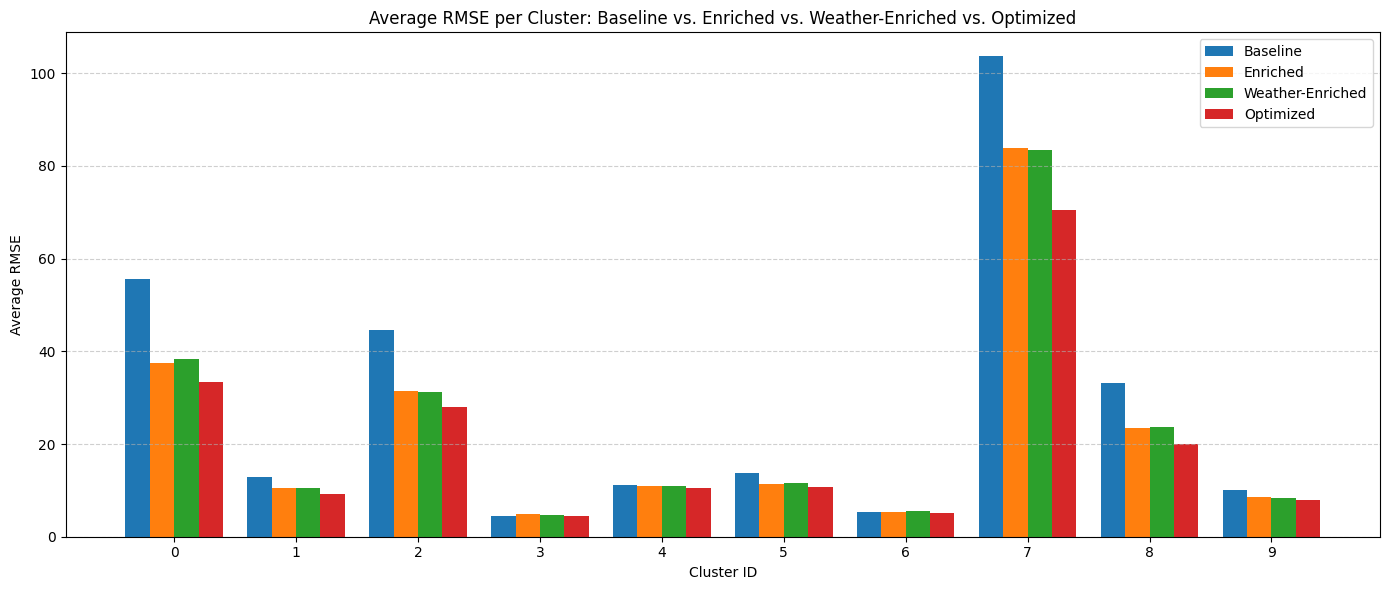

In [95]:
# Prepare lists for plotting
clusters = sorted(results_baseline.keys())
baseline_avgs = []
enriched_avgs = []
weather_enriched_avgs = []
results_optimized_avgs = []

# Compute average RMSEs over all window sizes
for cluster_id in clusters:
    baseline_vals = results_baseline[cluster_id]
    enriched_vals = results_enriched[cluster_id]
    weather_vals = results_weather_enriched[cluster_id]
    optimized_vals = results_optimized[cluster_id]

    baseline_avgs.append(baseline_vals)
    enriched_avgs.append(enriched_vals)
    weather_enriched_avgs.append(weather_vals)
    results_optimized_avgs.append(optimized_vals)

# Print values per cluster
print("Average RMSE per Cluster:\n")
print(f"{'Cluster':<10}{'Baseline':<12}{'Enriched':<12}{'Weather':<12}{'Optimized':<12}")
print("-" * 58)
for i, cluster_id in enumerate(clusters):
    print(f"{cluster_id:<10}{baseline_avgs[i]:<12.2f}{enriched_avgs[i]:<12.2f}{weather_enriched_avgs[i]:<12.2f}{results_optimized_avgs[i]:<12.2f}")

# Plot
x = np.arange(len(clusters))
width = 0.2

plt.figure(figsize=(14, 6))
plt.bar(x - 1.5*width, baseline_avgs, width, label='Baseline')
plt.bar(x - 0.5*width, enriched_avgs, width, label='Enriched')
plt.bar(x + 0.5*width, weather_enriched_avgs, width, label='Weather-Enriched')
plt.bar(x + 1.5*width, results_optimized_avgs, width, label='Optimized')

plt.xlabel('Cluster ID')
plt.ylabel('Average RMSE')
plt.title('Average RMSE per Cluster: Baseline vs. Enriched vs. Weather-Enriched vs. Optimized')
plt.xticks(x, clusters)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Key Findings of the Model Comparison:
- The optimized models, trained with best parameters from grid search, consistently achieved the lowest RMSE in all clusters.
- Enriched and Weather-Enriched models improved over the Baseline, especially in high-variance clusters like 0, 2, 7, and 8.
- The biggest improvements were seen in clusters with high baseline error (e.g., Cluster 7: from 103.63 → 70.39).
- In clusters with already low baseline error (e.g., Cluster 3 or 6), differences between models were minimal.
- This indicates that feature enhancements and hyperparameter tuning are most beneficial in complex or volatile clusters.

## Model Evaluation und Forecasting the Next 24 Hours

Using the best parameters from prior grid search, we train a model on all past data (excluding the final 24h) for each cluster. The next 24 hours are forecasted and compared to actual demand for evaluation.

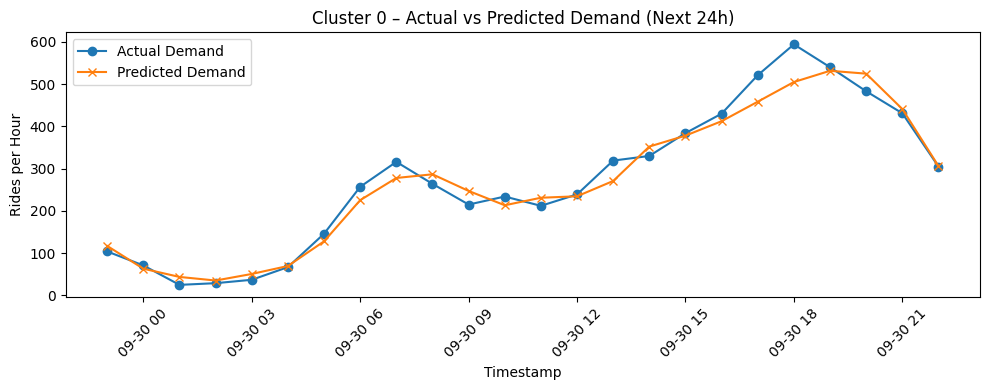

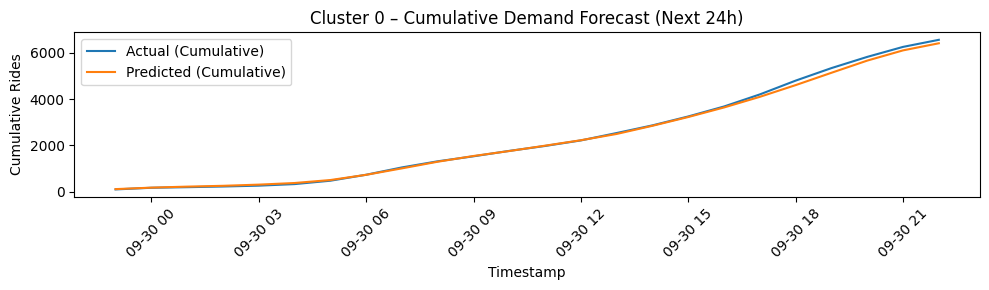

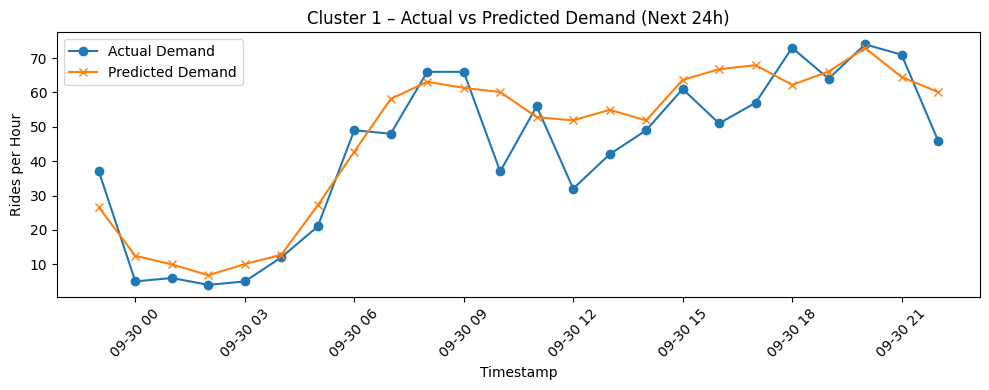

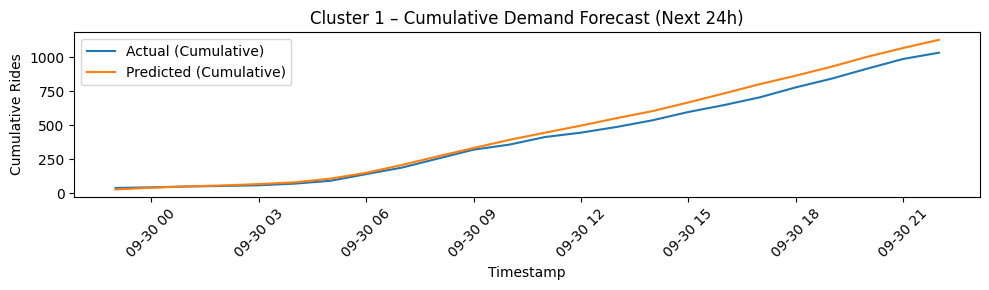

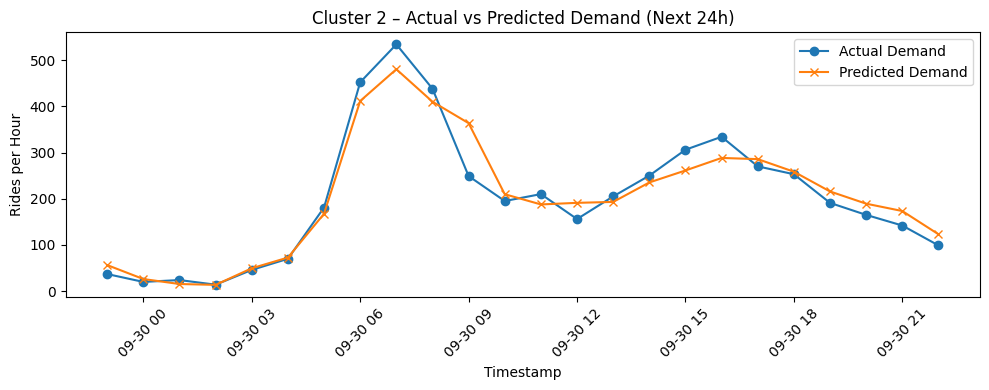

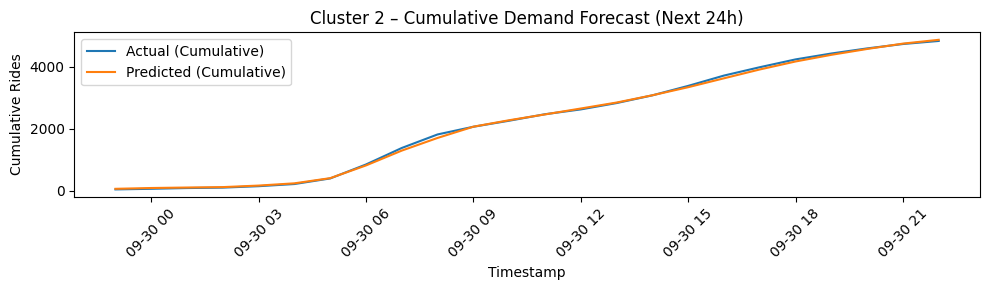

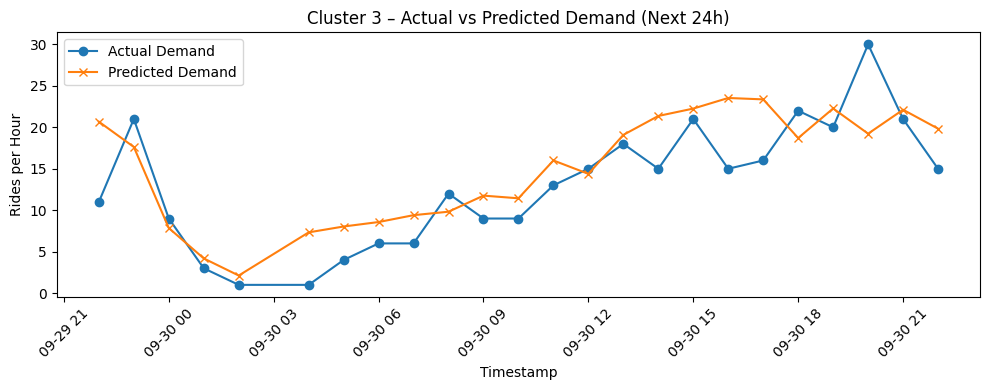

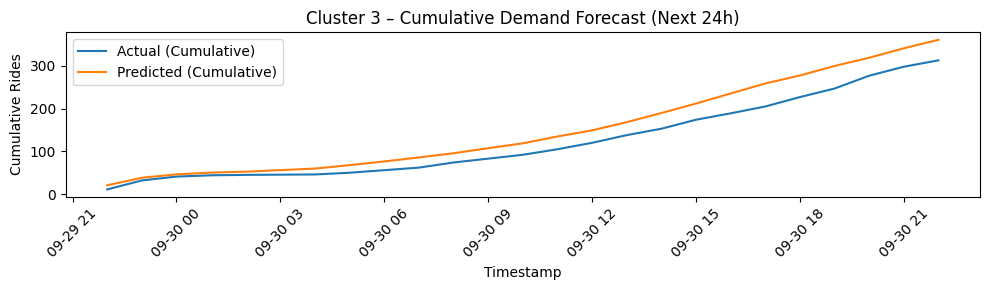

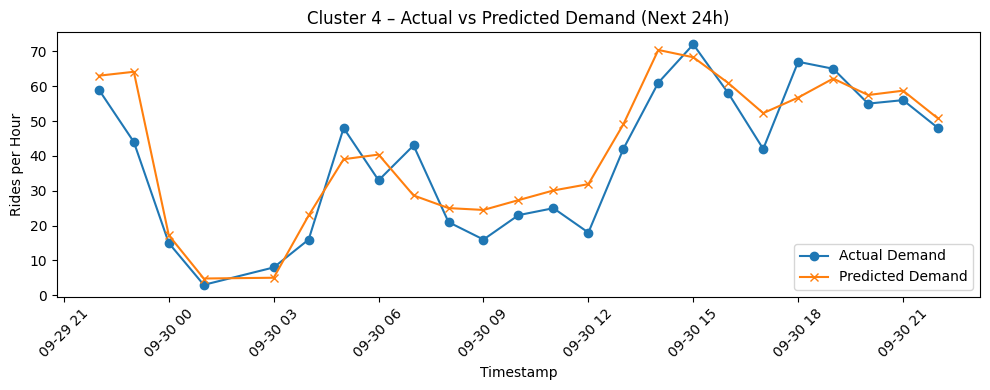

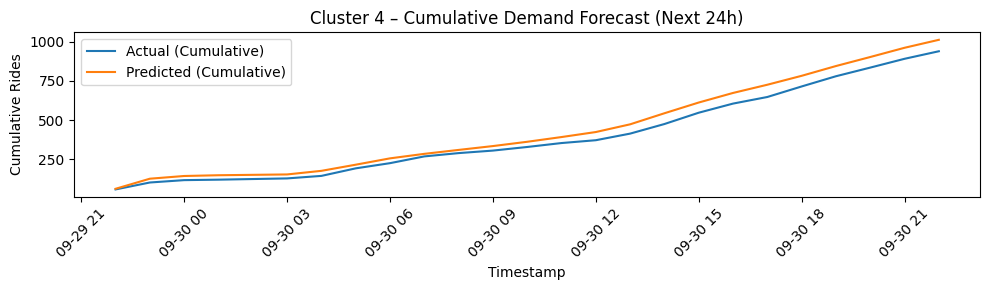

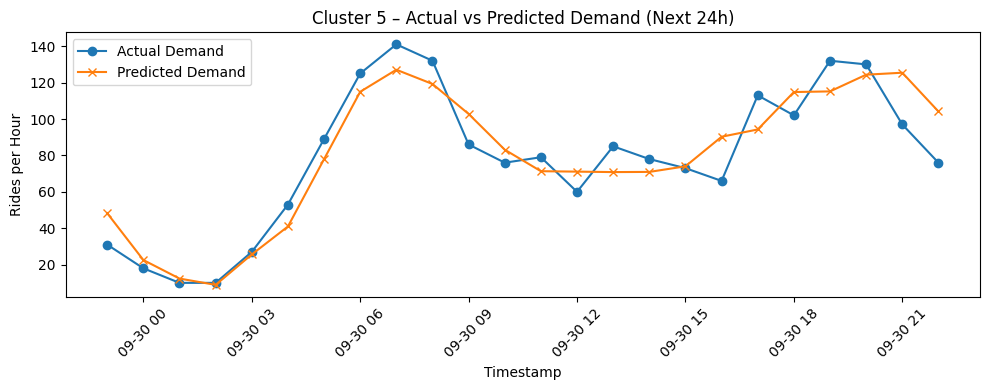

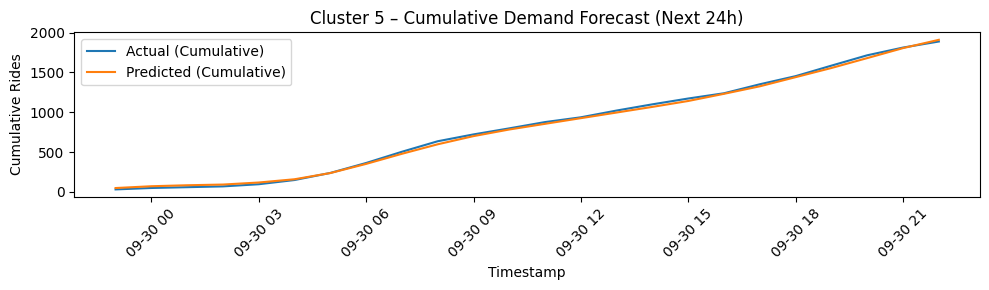

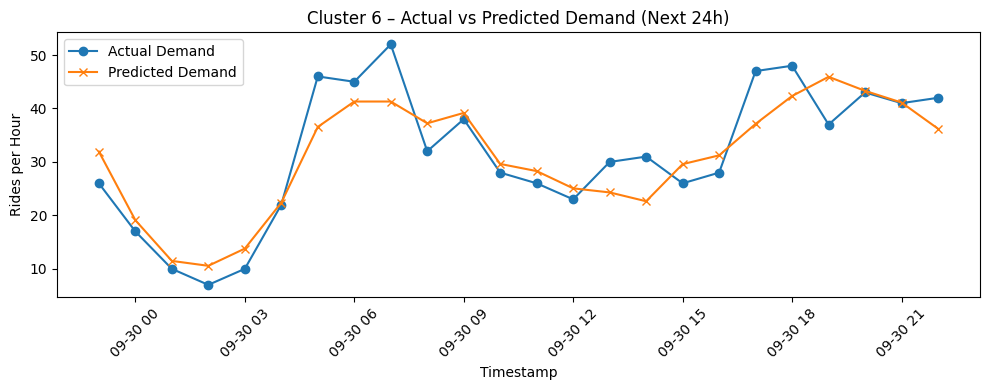

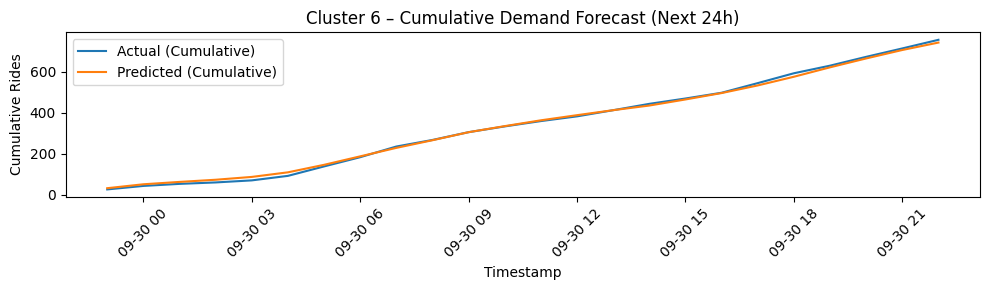

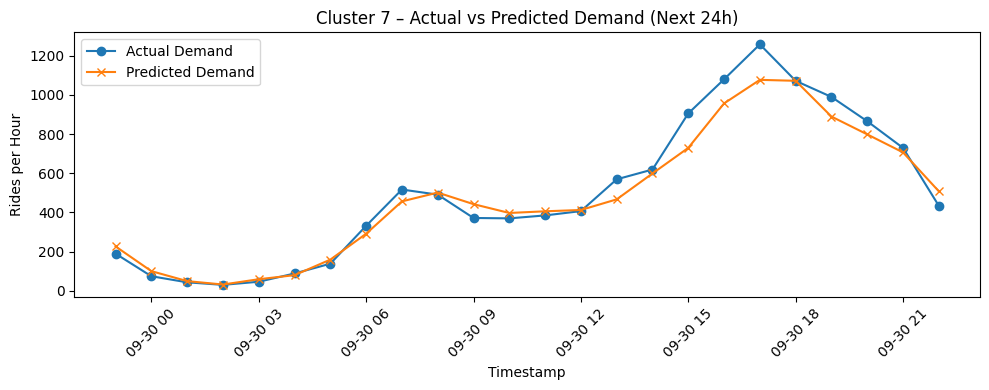

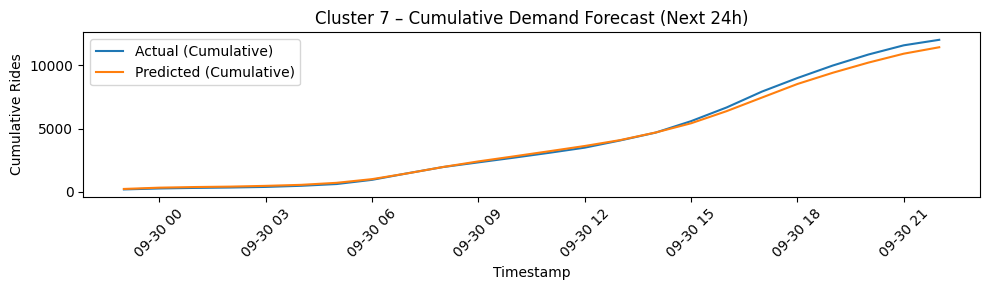

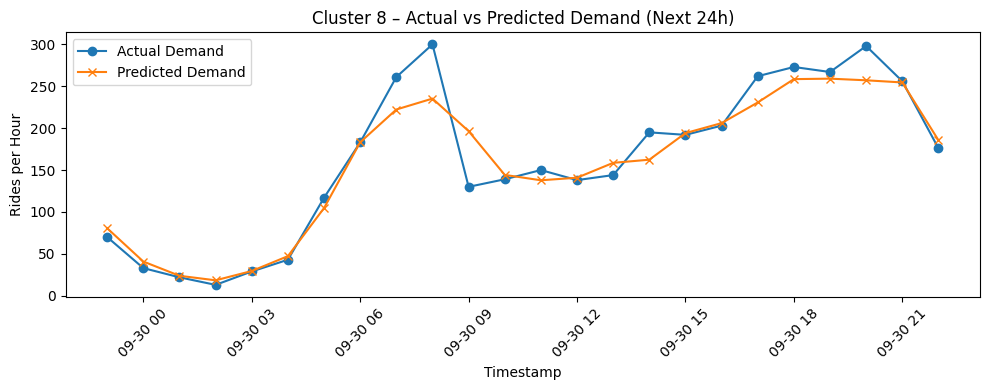

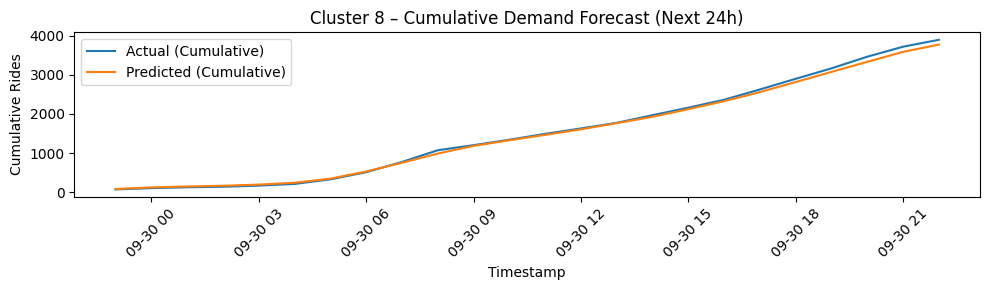

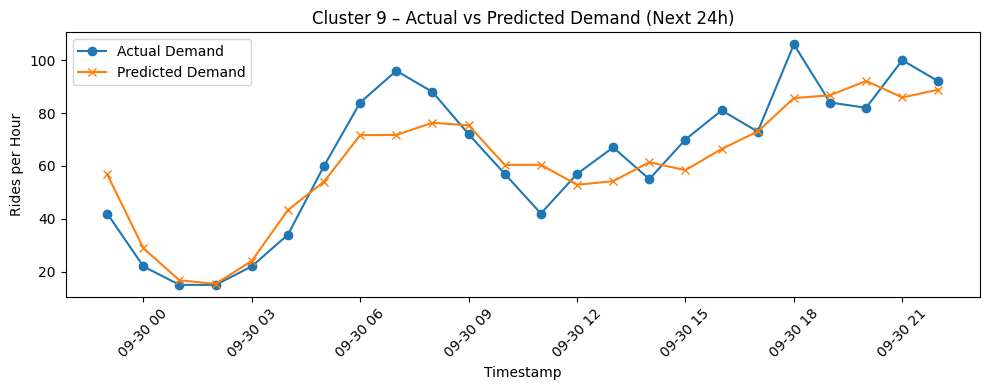

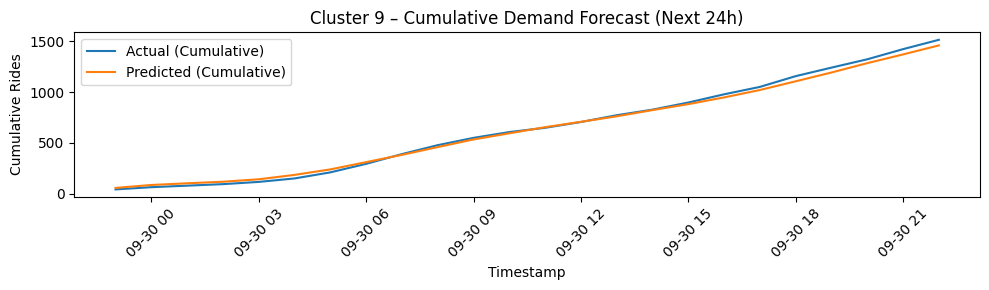


Summary of performance for all clusters:


,Cluster,Train_RMSE,Train_Daily_Demand_Error_%,Test_RMSE,Test_Daily_Demand_Error_%,Test_Hourly_MAPE_%
0,0,28.86,0.03,30.90,2.28,12.88
1,1,5.27,0.00,9.75,9.20,32.34
2,2,13.94,0.00,34.51,0.77,15.63
3,3,2.96,0.04,4.74,15.33,60.96
4,4,7.44,0.04,8.04,7.76,23.86
5,5,8.31,0.05,14.20,1.13,17.37
6,6,4.22,0.05,5.39,1.78,15.66
7,7,33.62,0.00,71.97,4.89,12.03
8,8,12.40,0.00,24.98,3.14,11.76
9,9,1.54,0.00,11.06,3.64,14.99


In [104]:
# Settings
unwanted_features = ['messagetimestamp', 'rides_per_hour']
forecast_horizon = 24  # number of hours to forecast
all_results = []

for i in range(10):
    cluster_df = globals()[f'cluster_{i}'].copy()

    # Skip if too little data
    if len(cluster_df) <= forecast_horizon:
        print(f"Cluster {i} does not have enough data.")
        continue

    # Check for best parameters
    if i not in best_params_dict:
        print(f"No best parameters found for Cluster {i}. Skipping.")
        continue

    feature_cols = [col for col in cluster_df.columns if col not in unwanted_features]

    # Split data
    train_df = cluster_df.iloc[:-forecast_horizon]
    test_df = cluster_df.iloc[-forecast_horizon:]

    X_train = train_df[feature_cols]
    y_train = train_df['rides_per_hour']
    X_test = test_df[feature_cols]
    y_test = test_df['rides_per_hour']

    # Initialize and train model
    params = best_params_dict[i]
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrics
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    pct_error_train = abs(y_train.sum() - y_pred_train.sum()) / y_train.sum() * 100 if y_train.sum() > 0 else np.nan
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    pct_error_test = abs(y_test.sum() - y_pred_test.sum()) / y_test.sum() * 100 if y_test.sum() > 0 else np.nan
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100

    # Save results
    all_results.append({
        'Cluster': i,
        'Train_RMSE': rmse_train,
        'Train_Daily_Demand_Error_%': pct_error_train,
        'Test_RMSE': rmse_test,
        'Test_Daily_Demand_Error_%': pct_error_test,
        'Test_Hourly_MAPE_%': mape_test
    })

    # Plot: actual vs predicted
    plt.figure(figsize=(10, 4))
    plt.plot(test_df['messagetimestamp'], y_test, label='Actual Demand', marker='o')
    plt.plot(test_df['messagetimestamp'], y_pred_test, label='Predicted Demand', marker='x')
    plt.title(f'Cluster {i} – Actual vs Predicted Demand (Next 24h)')
    plt.xlabel('Timestamp')
    plt.ylabel('Rides per Hour')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot: cumulative
    plt.figure(figsize=(10, 3))
    plt.plot(test_df['messagetimestamp'], y_test.cumsum(), label='Actual (Cumulative)')
    plt.plot(test_df['messagetimestamp'], pd.Series(y_pred_test).cumsum(), label='Predicted (Cumulative)')
    plt.title(f'Cluster {i} – Cumulative Demand Forecast (Next 24h)')
    plt.xlabel('Timestamp')
    plt.ylabel('Cumulative Rides')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Summary
summary_df = pd.DataFrame(all_results).round(2)
print("\nSummary of performance for all clusters:")
summary_df

### Key Findings of the 24-Hour Forecast with Optimized Models:
- The models, trained with best parameters from grid search, deliver reliable short-term forecasts across most clusters.
- Clusters 0, 5, 6, 8, and 9 show low test errors, indicating strong predictive performance.
- Cluster 7 remains the most challenging, with the highest RMSE (71.97) despite optimization—suggesting high demand volatility.
- MAPE values vary by cluster, with the highest in clusters with low or irregular demand (e.g., Cluster 3: 60.96%).
- In most clusters, daily demand prediction errors remain under 5%, showing accurate aggregation over the forecast horizon.
- The results confirm that optimized models generalize well for next-day forecasting, especially in stable demand environments.